In [ ]:
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def swish(x):
    return x * sigmoid(x)

def softplus(x):
    return np.log(1 + np.exp(x))

def invented(x):
    return np.where(x >= 0, x, sigmoid(x) * (np.exp(x) - 1))

In [ ]:
class MyNet(nn.Module):
    def __init__(self, activation):
        super(MyNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)
        self.activation1 = activation
        self.linear2 = nn.Linear(128, 64)
        self.activation2 = activation
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)
        x = torch.tensor(self.activation1(x.detach().numpy()))
        x = self.linear2(x)
        x = torch.tensor(self.activation2(x.detach().numpy()))
        x = self.linear3(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 448kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.64MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def train_model(model, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(test_accuracy)

        print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_losses, test_accuracies


In [ ]:
activations = {
    'ReLU': relu,
    'GELU': gelu,
    'Swish': swish,
    'Softplus': softplus,
    'Invented': invented
}
results = {}

for name, activation in activations.items():
    print(f"Training with {name} activation")
    model = MyNet(activation=activation)
    train_loss, test_loss, test_accuracy = train_model(model)
    results[name] = {
        'train_loss':train_loss,
        'test_loss':test_loss,
        'test_accuracy': test_accuracy
    }
    print("-" * 30)

Training with ReLU activation
Epoch: 1/5, Train Loss: 1.9392, Test Loss: 1.6434, Test Accuracy: 66.36%
Epoch: 2/5, Train Loss: 1.4786, Test Loss: 1.3244, Test Accuracy: 69.57%
Epoch: 3/5, Train Loss: 1.2459, Test Loss: 1.1525, Test Accuracy: 71.01%
Epoch: 4/5, Train Loss: 1.1122, Test Loss: 1.0484, Test Accuracy: 71.89%
Epoch: 5/5, Train Loss: 1.0271, Test Loss: 0.9792, Test Accuracy: 73.00%
------------------------------
Training with GELU activation
Epoch: 1/5, Train Loss: 1.8766, Test Loss: 1.5397, Test Accuracy: 69.27%
Epoch: 2/5, Train Loss: 1.3770, Test Loss: 1.2083, Test Accuracy: 72.55%
Epoch: 3/5, Train Loss: 1.1435, Test Loss: 1.0371, Test Accuracy: 74.30%
Epoch: 4/5, Train Loss: 1.0130, Test Loss: 0.9333, Test Accuracy: 75.74%
Epoch: 5/5, Train Loss: 0.9298, Test Loss: 0.8650, Test Accuracy: 76.47%
------------------------------
Training with Swish activation
Epoch: 1/5, Train Loss: 1.8721, Test Loss: 1.5277, Test Accuracy: 69.39%
Epoch: 2/5, Train Loss: 1.3452, Test Loss: 1

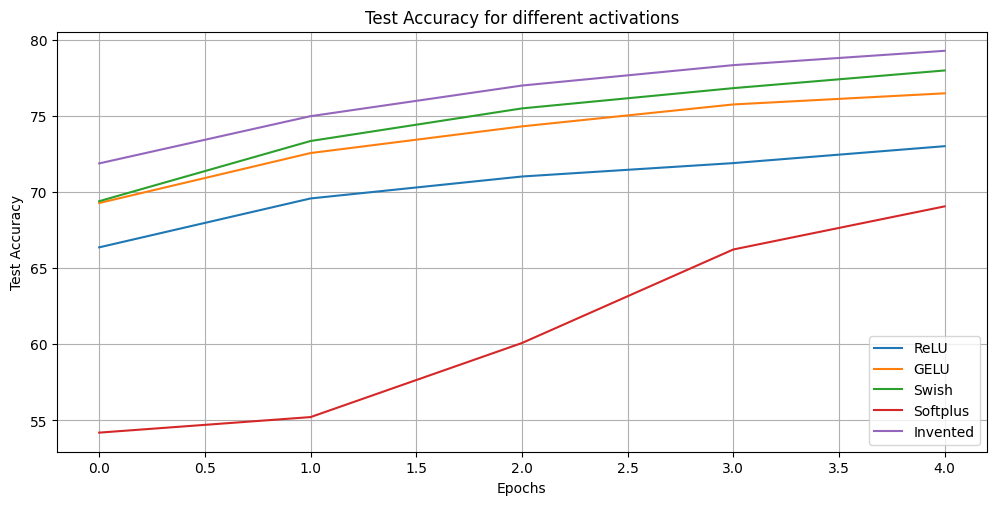

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
for name, result in results.items():
    plt.plot(result['test_accuracy'], label=f'{name}')
plt.title('Test Accuracy for different activations')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

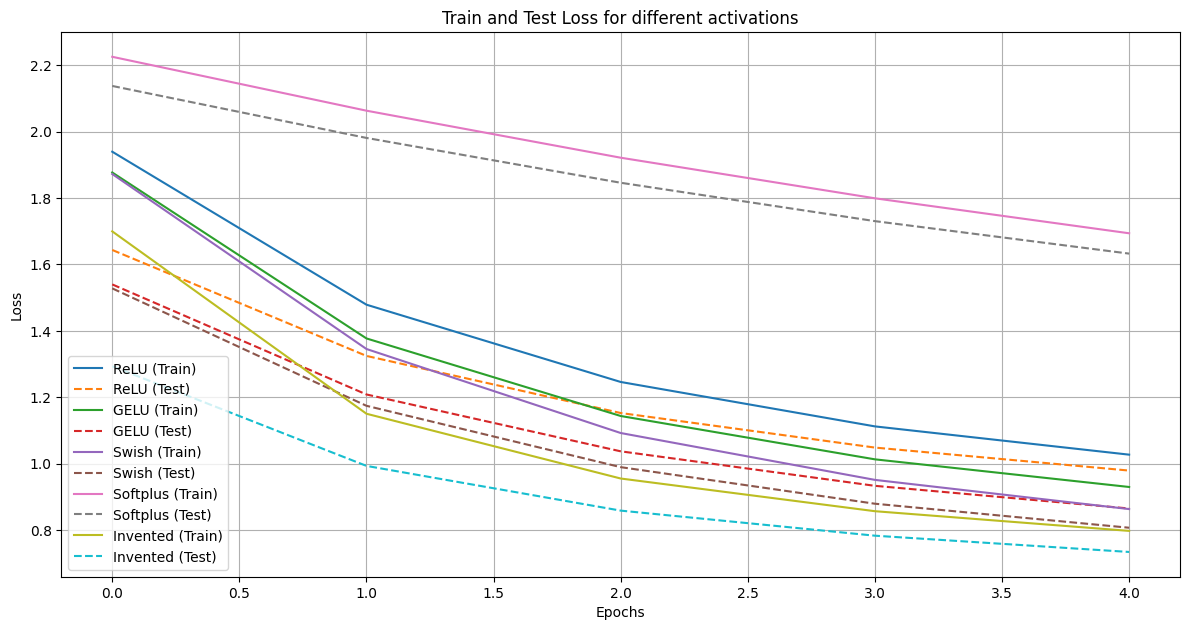

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 2)
for name, result in results.items():
    plt.plot(result['train_loss'], label=f'{name} (Train)')
    plt.plot(result['test_loss'], label=f'{name} (Test)', linestyle='--')
plt.title('Train and Test Loss for different activations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()